In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import os
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
# Mount Google Drive (for Google Colab users)
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
dataset_path = "/content/drive/MyDrive/Road Signs classification dataset/DATA"
test_path = "/content/drive/MyDrive/Road Signs classification dataset/TEST"
labels_path = "/content/drive/MyDrive/Road Signs classification dataset/labels.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

labels_path = "/content/drive/MyDrive/Road Signs classification dataset/labels.csv"
labels_df = pd.read_csv(labels_path)

# Show first few rows to confirm it loaded correctly
labels_df.head()


,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)


In [ ]:
labels_df.tail()

,ClassId,Name
25,25,keep Left
26,26,keep Right
27,27,Roundabout mandatory
28,28,watch out for cars
29,29,Horn


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory  # Correct import

# Ensure numeric sorting of classes
class_names = sorted(os.listdir(dataset_path), key=lambda x: int(x))
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(64, 64),
    batch_size=32,
    seed=123,
    validation_split=False
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle= False,
    image_size=(64, 64),
    batch_size=32,
    seed=123,
    validation_split=False,
)


print("✅ Final Class Order:", class_names)

Found 743 files belonging to 30 classes.
Found 743 files belonging to 30 classes.
✅ Final Class Order: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29']


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    image_size=(64, 64),
    batch_size=32,
    validation_split=False
)


Found 285 files belonging to 30 classes.


In [ ]:


class_names = train_ds.class_names
num_classes = len(class_names)
print(f"number of classes : {num_classes}")

number of classes : 30


In [ ]:


# Ensure ClassId is int in case it's read as string from CSV
labels_df['ClassId'] = labels_df['ClassId'].astype(int)

# Create mapping dictionary
class_mapping = dict(zip(labels_df['ClassId'], labels_df['Name']))

# Safely map class indices to their names
# Ensure ClassId is int in case it's read as string from CSV
labels_df['ClassId'] = labels_df['ClassId'].astype(int)

# Create mapping dictionary
class_mapping = dict(zip(labels_df['ClassId'], labels_df['Name']))

# Safely map class indices to their names
try:
    class_names = [class_mapping[int(cls)] for cls in class_names]
    print(f"Class Names : {class_names}")
except KeyError as e:
    print(f"Error: Class ID {e} not found in labels_df. Please verify all class IDs exist.")

Class Names : ['Speed limit (5km/h)', 'Speed limit (15km/h)', 'Dont Go straight', 'Dont Go Left', 'Dont Go Left or Right', 'Dont Go Right', 'Dont overtake from Left', 'No Uturn', 'No Car', 'No horn', 'No entry', 'No stopping', 'Speed limit (30km/h)', 'Go straight or right', 'Go straight', 'Go Left', 'Go Left or right', 'Go Right', 'keep Left', 'keep Right', 'Roundabout mandatory', 'watch out for cars', 'Horn', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'speed limit (80km/h)', 'Dont Go straight or left', 'Unknown7']


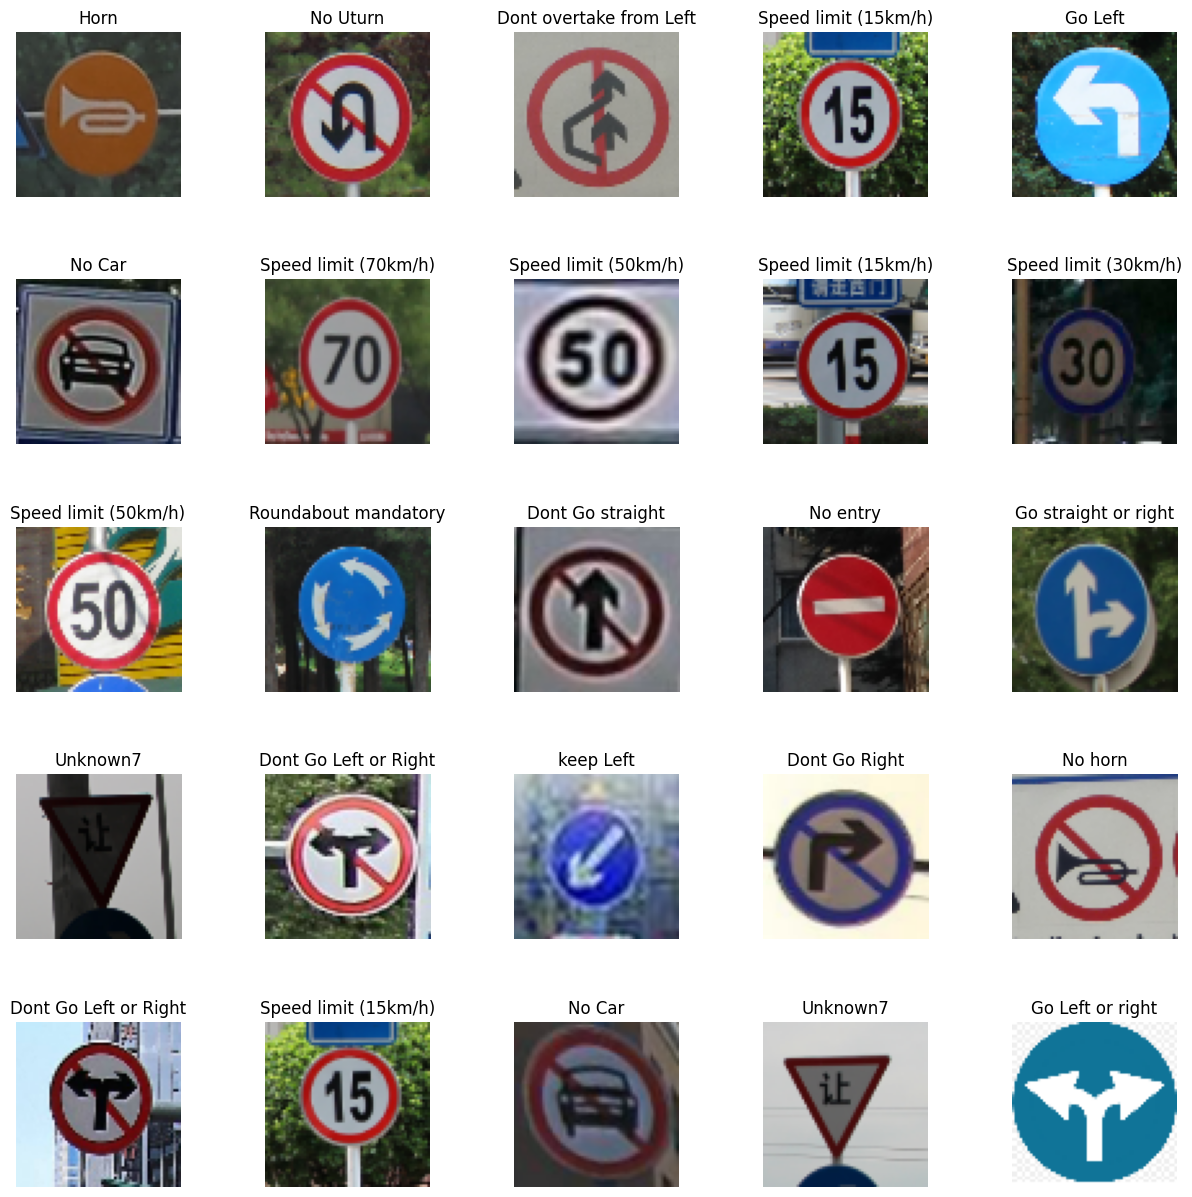

In [ ]:

plt.figure(figsize=(15, 15))

for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()

    for i in range(min(25, images.shape[0])):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [ ]:

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [ ]:


def process(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    image = data_augmentation(image)
    label = tf.one_hot(label, depth=num_classes)
    return image, label

# Apply to datasets
train_ds = train_ds.map(process).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(process).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf
# Model
model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),

    # First Conv Block
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Second Conv Block
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Third Conv Block
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Flatten Layer
    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.0523 - loss: 3.4072 - val_accuracy: 0.0808 - val_loss: 3.2132
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 537ms/step - accuracy: 0.0880 - loss: 3.1826 - val_accuracy: 0.1521 - val_loss: 2.8749
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 601ms/step - accuracy: 0.1652 - loss: 2.7989 - val_accuracy: 0.2719 - val_loss: 2.6481
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 572ms/step - accuracy: 0.2473 - loss: 2.6493 - val_accuracy: 0.3217 - val_loss: 2.2497
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 590ms/step - accuracy: 0.3201 - loss: 2.2536 - val_accuracy: 0.4105 - val_loss: 1.9949
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 633ms/step - accuracy: 0.3707 - loss: 2.1050 - val_accuracy: 0.5101 - val_loss: 1.6687
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 574ms/step - accuracy: 0.5010 - loss: 1.6726 - val_accuracy: 0.6110 - val_loss: 1.3502
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 790ms/step - accuracy: 0.5077 - loss: 1.6132 - val_accurac

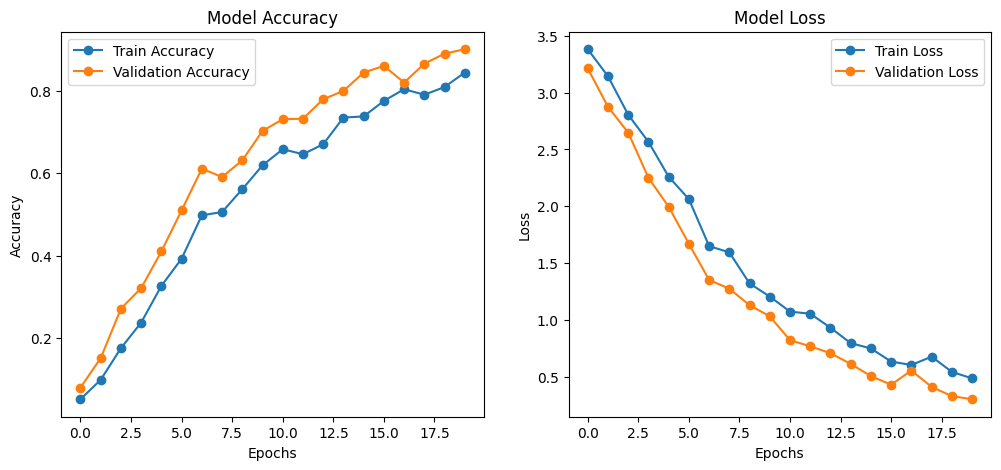

In [ ]:

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

     Speed limit (5km/h)       1.00      0.25      0.40         4
    Speed limit (15km/h)       0.40      0.67      0.50         6
        Dont Go straight       0.52      1.00      0.69        12
            Dont Go Left       0.80      0.18      0.30        22
   Dont Go Left or Right       0.00      0.00      0.00         9
           Dont Go Right       0.32      1.00      0.49        11
 Dont overtake from Left       1.00      0.50      0.67         2
                No Uturn       0.43      0.67      0.53        15
                  No Car       0.00      0.00      0.00        11
                 No horn       0.50      0.11      0.17        19
                No entry       0.00      0.00      0.00        10
             No stopping       0.00      0.00      0.00        10
    Speed limit (30km/h)       0.19      1.00      0.32        10
    Go straight or right       0.50      1.00      0.67         2
         

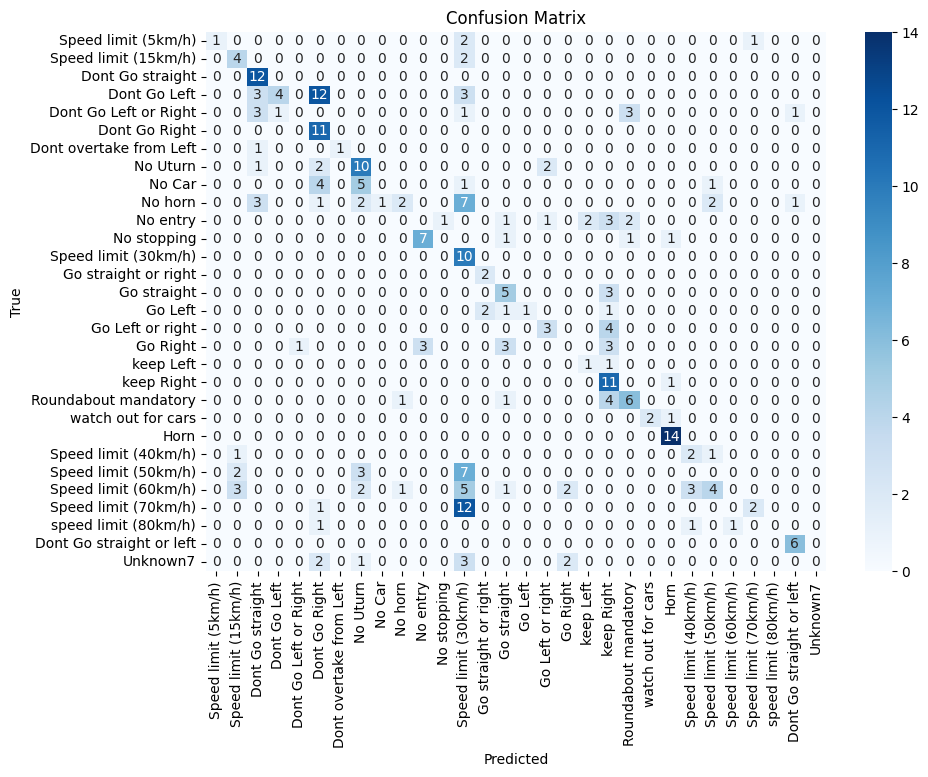

In [ ]:


from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predictions
true_labels = []
predictions = []

# Loop over batches in test dataset
for images, labels in test_ds:
    # If labels are one-hot encoded (categorical), convert them to integer labels
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert to int labels

    # Get model predictions
    pred = model.predict(images)
    predicted_class = np.argmax(pred, axis=1)
    predictions.extend(predicted_class)

# Print the classification report
print(classification_report(true_labels, predictions, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def predict_image(image_path):
    # Load and preprocess image
    image = tf.keras.utils.load_img(image_path, target_size=(64, 64))
    input_arr = tf.keras.utils.img_to_array(image) / 255.0  # Normalize
    img_bat = tf.expand_dims(input_arr, axis=0)  # Add batch dimension

    # Predict
    predictions = model.predict(img_bat)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_names[predicted_class]

    # Plot image with prediction
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}", fontsize=14)
    plt.axis('off')
    plt.show()

    return predicted_label





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


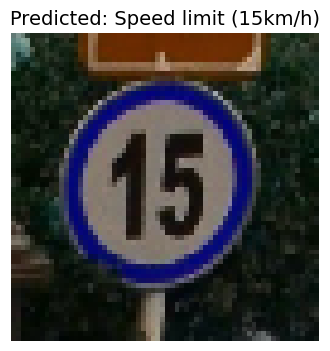

'Speed limit (15km/h)'

In [ ]:
predict_image("/content/drive/MyDrive/Road Signs classification dataset/TEST/1/001_1_0003_1_j.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


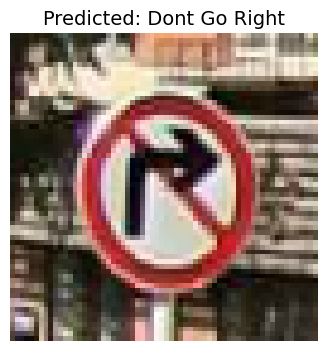

'Dont Go Right'

In [ ]:
predict_image("/content/drive/MyDrive/Road Signs classification dataset/DATA/13/013_0022_j.png")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


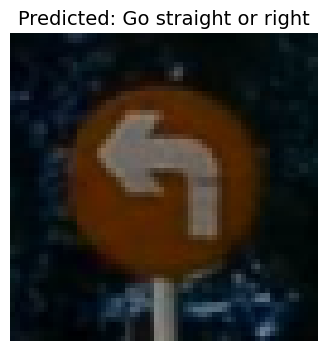

'Go straight or right'

In [ ]:
predict_image("/content/drive/MyDrive/Road Signs classification dataset/TEST/22/022_0005_j.png")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


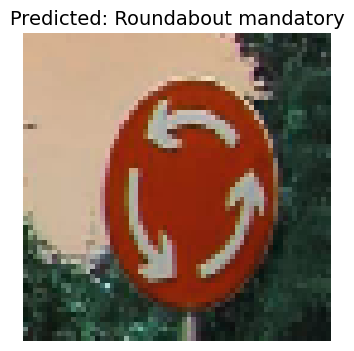

'Roundabout mandatory'

In [ ]:
predict_image("/content/drive/MyDrive/Road Signs classification dataset/TEST/27/027_0006_j.png")

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess(image_path):
    image = tf.keras.utils.load_img(image_path, target_size=(64, 64))
    input_arr = tf.keras.utils.img_to_array(image) / 255.0
    img_bat = tf.expand_dims(input_arr, axis=0)
    return image, img_bat

def predict_images_in_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    cols = 3
    rows = (len(image_files) + cols - 1) // cols

    plt.figure(figsize=(cols * 4, rows * 4))

    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        image, img_bat = load_and_preprocess(image_path)

        predictions = model.predict(img_bat)
        predicted_class = np.argmax(predictions, axis=1)[0]
        predicted_label = class_names[predicted_class]

        plt.subplot(rows, cols, idx + 1)
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_label}", fontsize=18)
        plt.axis('off')

    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


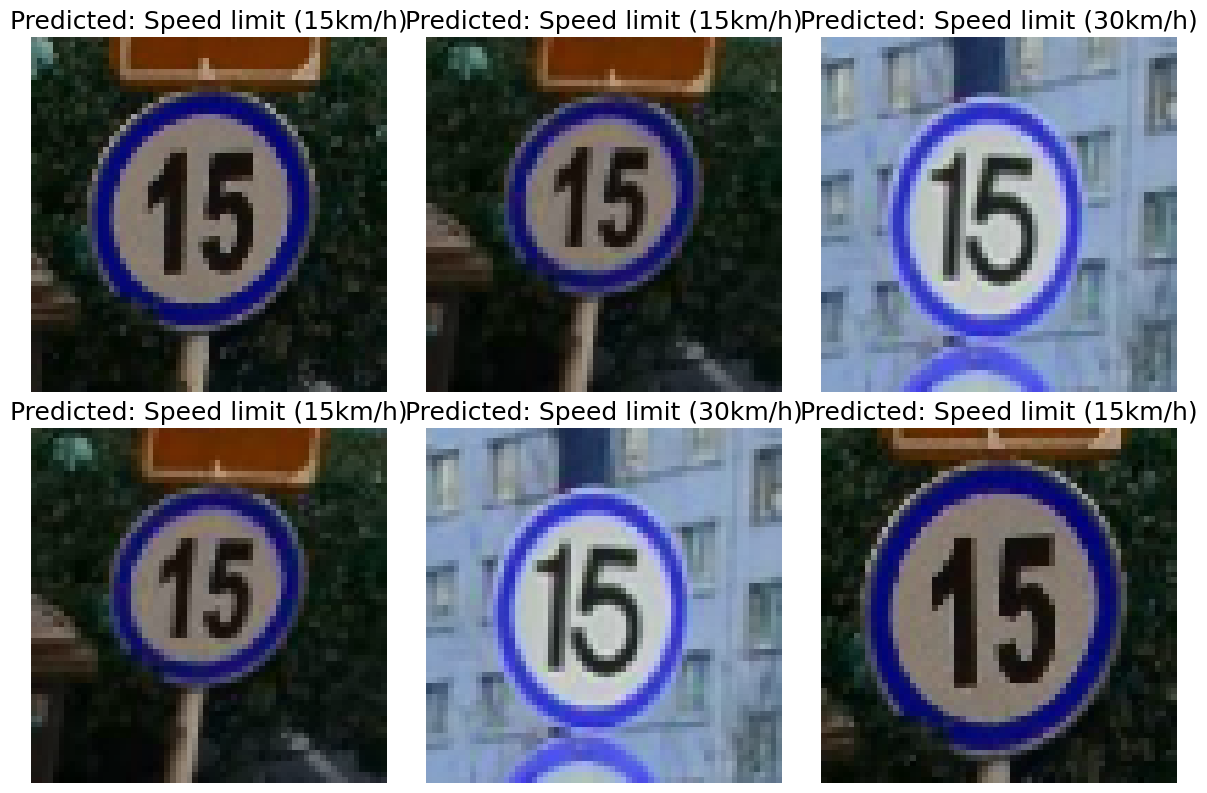

In [ ]:


folder_path = "/content/drive/MyDrive/Road Signs classification dataset/TEST/1"
predict_images_in_folder(folder_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


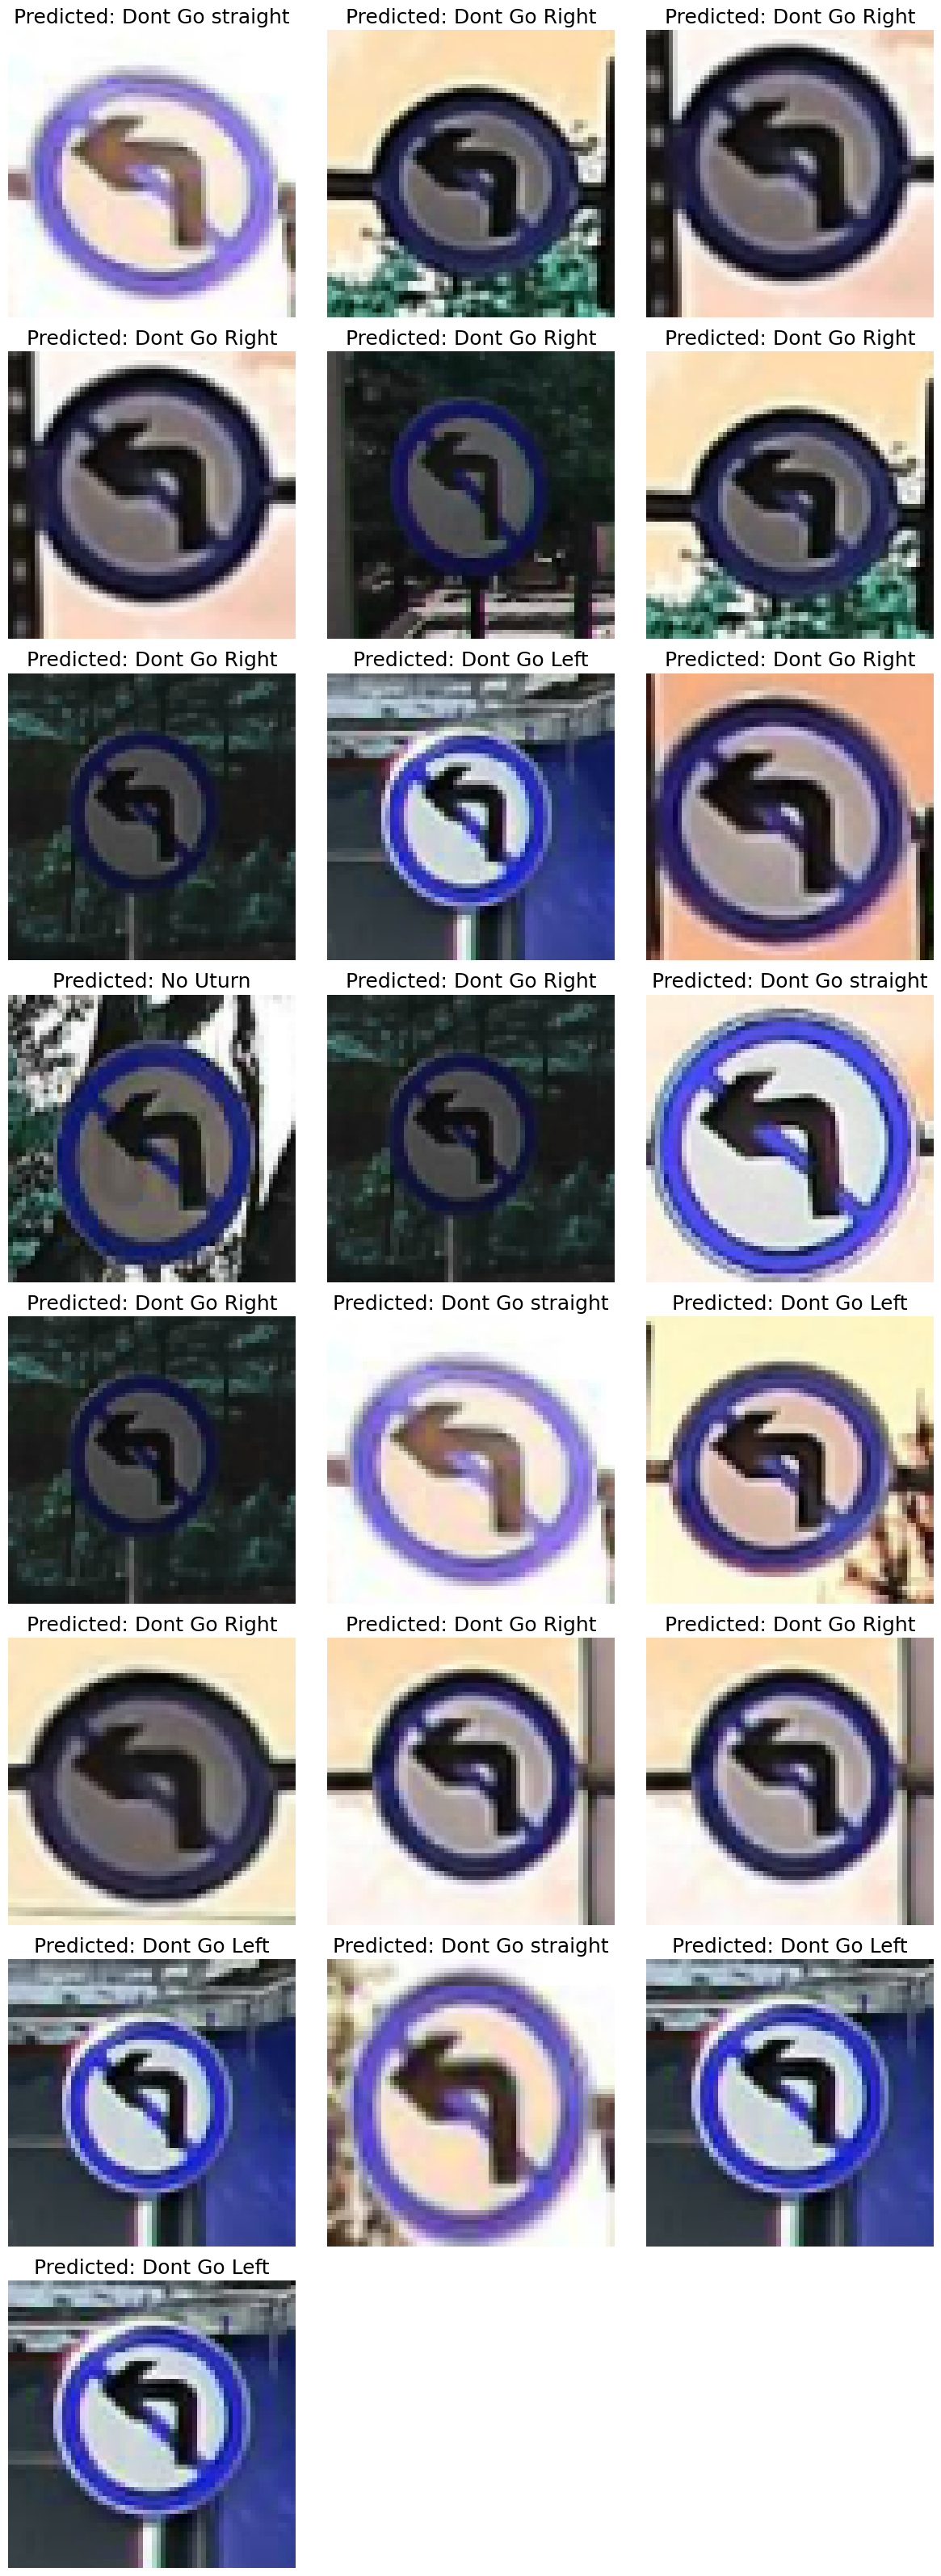

In [ ]:


folder_path = "/content/drive/MyDrive/Road Signs classification dataset/TEST/11"
predict_images_in_folder(folder_path)

In [ ]:

pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

# Define the model building function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()

    # First Conv layer
    model.add(layers.Conv2D(
        filters=hp.Choice('filters_1', [32, 64, 128]),
        kernel_size=3,
        activation='relu',
        input_shape=(64, 64, 3)
    ))
    model.add(layers.MaxPooling2D())

    # Second Conv layer
    model.add(layers.Conv2D(
        filters=hp.Choice('filters_2', [64, 128, 192]),
        kernel_size=3,
        activation='relu'
    ))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())

    # Dense layer
    model.add(layers.Dense(
        units=hp.Choice('dense_units', [128, 256, 384, 512]),
        activation='relu'
    ))

    # Dropout
    model.add(layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))


     # Output layer
    # Assuming num_classes is defined elsewhere and is 30 based on the original model
    # Use the actual num_classes determined from your dataset
    # If num_classes is not globally available here, you might need to pass it or define it.
    # Based on your previous code, num_classes is available.
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        # Change the loss function to 'categorical_crossentropy'
        # because your dataset yields one-hot encoded labels.
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Create a tuner instance
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='road_sign_tuning'
)

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Run the tuner
tuner.search(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stop])


Trial 10 Complete [00h 03m 39s]
val_accuracy: 0.8815612196922302

Best val_accuracy So Far: 0.897711992263794
Total elapsed time: 00h 38m 08s


In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Filters 1: {best_hp.get('filters_1')}")
print(f"Filters 2: {best_hp.get('filters_2')}")
print(f"Dense units: {best_hp.get('dense_units')}")
print(f"Dropout: {best_hp.get('dropout')}")
print(f"Learning rate: {best_hp.get('learning_rate')}")

# Build the best model
best_model = tuner.hypermodel.build(best_hp)

# Train the best model fully
history = best_model.fit(train_ds, validation_data=val_ds, epochs=10)


Best Hyperparameters:
Filters 1: 32
Filters 2: 128
Dense units: 512
Dropout: 0.4
Learning rate: 0.001
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 730ms/step - accuracy: 0.0450 - loss: 3.8207 - val_accuracy: 0.1938 - val_loss: 2.9483
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 764ms/step - accuracy: 0.1796 - loss: 2.9127 - val_accuracy: 0.3445 - val_loss: 2.4157
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 989ms/step - accuracy: 0.3354 - loss: 2.4738 - val_accuracy: 0.4953 - val_loss: 1.9192
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 720ms/step - accuracy: 0.4430 - loss: 1.9950 - val_accuracy: 0.5316 - val_loss: 1.7623
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 770ms/step - accuracy: 0.4797 - loss: 1.7877 - val_accuracy: 0.6635 - val_loss: 1.3533
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 715ms/step - accuracy: 0.5477 - loss: 1.5506 - val_accuracy: 0.7214 - val_loss: 1.0434
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 768ms/step - accuracy: 0.6543 - loss: 1.2665 - val_accuracy: 0.7712 - val_loss: 0.

In [ ]:
# Save in the .keras format (TensorFlow's recommended format)
best_model.save("/content/drive/MyDrive/RoadSign_Model_Best.keras")
print("✅ Model saved as RoadSign_Model_Best.keras")

# Save in the .h5 format (widely supported, including older tools)
best_model.save("/content/drive/MyDrive/RoadSign_Model_Best.h5")
print("✅ Model saved as RoadSign_Model_Best.h5")


✅ Model saved as RoadSign_Model_Best.keras
✅ Model saved as RoadSign_Model_Best.h5


In [ ]:

!pip install streamlit pyngrok -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

import streamlit as st
import numpy as np
import tensorflow as tf
from PIL import Image
import pandas as pd

# 🔧 This must come before any other Streamlit command
st.set_page_config(page_title="Road Sign Classifier", layout="centered")

# Load trained model (.h5 or .keras)
@st.cache_resource
def load_model():
    model_path = "/content/drive/MyDrive/RoadSign_Model_Best.h5"
    return tf.keras.models.load_model(model_path)

# Load labels
@st.cache_data
def load_labels():
    labels_path = "/content/drive/MyDrive/Road Signs classification dataset/labels.csv"
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

# Define the model building function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()

    # First Conv layer
    model.add(layers.Conv2D(
        filters=hp.Choice('filters_1', [32, 64, 128]),
        kernel_size=3,
        activation='relu',
        input_shape=(64, 64, 3)
    ))
    model.add(layers.MaxPooling2D())

    # Second Conv layer
    model.add(layers.Conv2D(
        filters=hp.Choice('filters_2', [64, 128, 192]),
        kernel_size=3,
        activation='relu'
    ))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())

    # Dense layer
    model.add(layers.Dense(
        units=hp.Choice('dense_units', [128, 256, 384, 512]),
        activation='relu'
    ))

    # Dropout
    model.add(layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))


     # Output layer
    # Assuming num_classes is defined elsewhere and is 30 based on the original model
    # Use the actual num_classes determined from your dataset
    # If num_classes is not globally available here, you might need to pass it or define it.
    # Based on your previous code, num_classes is available.
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        # Change the loss function to 'categorical_crossentropy'
        # because your dataset yields one-hot encoded labels.
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model/labels.csv"
    df = pd.read_csv(labels_path)
    df["ClassId"] = df["ClassId"].astype(str)
    return df.set_index("ClassId")["Name"].to_dict()

model = load_model()
class_id_to_name = load_labels()

# Preprocessing function
def preprocess_image(image: Image.Image):
    image = image.resize((64, 64))
    image_array = np.array(image) / 255.0
    if image_array.shape[-1] == 4:  # Handle RGBA images
        image_array = image_array[..., :3]
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Streamlit UI
st.title("🚦 Road Sign Classification")
st.markdown("Upload an image of a road sign to classify it using a trained deep learning model.")

uploaded_file = st.file_uploader("📁 Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="🖼 Uploaded Image", use_column_width=True)

    if st.button("🔍 Classify"):
        with st.spinner("🔎 Predicting the road sign..."):
            # Preprocess image
            image_array = preprocess_image(image)

            # Make prediction
            predictions = model.predict(image_array)[0]
            predicted_idx = np.argmax(predictions)
            confidence = predictions[predicted_idx] * 100
            predicted_class = str(predicted_idx)
            predicted_name = class_id_to_name.get(predicted_class, "Unknown")

        # Display top prediction
        st.markdown("---")
        st.success(f"### 🏷 Predicted Road Sign: **{predicted_name}**")
        st.info(f"🔢 Class ID: `{predicted_class}`")
        st.info(f"💡 Confidence Score: **{confidence:.2f}%**")

        # Confidence Warning
        if confidence < 50:
            st.warning("⚠️ Confidence is low. The model might be unsure about this prediction.")

        # Show Top-3 Predictions
        top_3_indices = predictions.argsort()[-3:][::-1]
        st.markdown("#### 📊 Top 3 Predictions:")
        for idx in top_3_indices:
            label = class_id_to_name.get(str(idx), "Unknown")
            prob = predictions[idx] * 100
            st.write(f"🔸 **{label}** — `{prob:.2f}%`")



Writing app.py


In [ ]:
!ngrok authtoken 2ussbycOHN7zsRy2Sh7mIMLIDAU_4bVKfp5B6mS72dBtEBp5V
!streamlit run app.py &>/dev/null&

In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print("Streamlit App is running at:", public_url)


In [ ]:


!pkill streamlit
!pkill ngrok